# Testing the Model Deployment

After deploying the model using RHOAI Model Serving, we'd like to test the model deployment by sending images to the model server for real-time inference.

In this notebook we'll review how to consume the model through the RHOAI Model Server.

We'll start by importing the preprocessing and rendering functions that we have worked with in the previous notebook.

In [1]:
# Set the new value for the iopub_data_rate_limit
new_limit = 2000000  # Example: setting the limit to 2 MB/s

# Import the IPython module to access notebook configuration settings
from IPython.core.display import display, HTML
import IPython

# Update the notebook configuration to set the new limit
IPython.get_ipython().config.IPKernelApp.iopub_data_rate_limit = new_limit

# Display a message to inform the user
display(HTML(f"<div style='color: green;'>IOPub data rate limit set to {new_limit} bytes/sec.</div>"))

IPython.get_ipython().config.IPKernelApp.iopub_data_rate_limit = 10000000


/tmp/ipykernel_8929/1108800201.py:5: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from requests import post
import torch


Let's prepare sample images as a test sample.

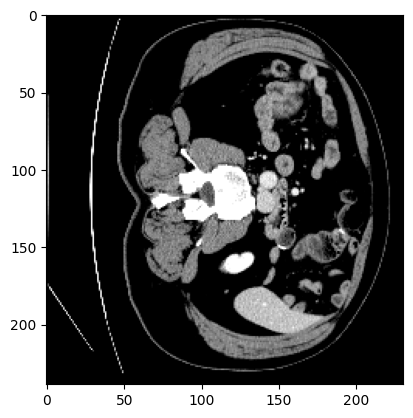

In [3]:
mydata_infer_image = torch.load("infer_image.npy")
mydata_infer_image.size()
mydata_infer_image.squeeze().size()
plt.imshow(mydata_infer_image.squeeze()[:, :, 20], cmap="gray")

Shape of the loaded array: (219, 173, 84)
Size of the loaded array: 3182508
Size after squeezing: 3182508


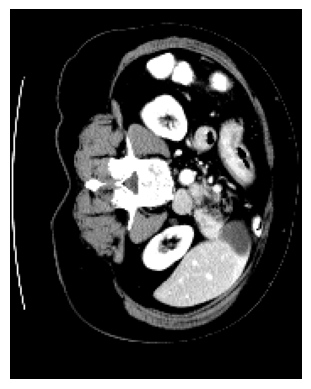

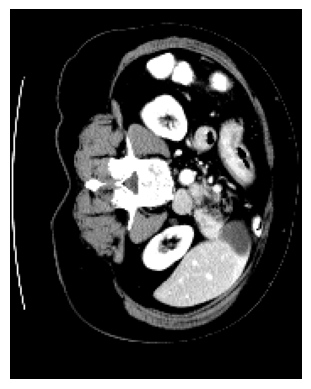

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Load the saved NumPy array before pre-processing for input size correction
image = np.load("image_0.npy")

# Check the shape of the array
print("Shape of the loaded array:", image.shape)

# Check the size of the loaded array
print("Size of the loaded array:", image.size)

# Check the size after squeezing the array
print("Size after squeezing:", image.squeeze().size)

# Visualize a slice of the image along the third dimension (depth)You're visualizing a slice of the original 3D array image along its third dimension (depth). The slice_index variable determines which slice along the depth dimension you're visualizing.
slice_index = 20  # Change this index as needed
plt.imshow(image[:, :, slice_index], cmap="gray")
plt.axis("off")
plt.show()


# Visualize a slice of the squeezed array You're visualizing a slice of the squeezed 3D array image. Since you've squeezed the array, the singleton dimensions have been removed, and you're left with a 2D array. Therefore, you're visualizing a slice along the depth dimension of this squeezed 2D array.
plt.imshow(image.squeeze()[:, :, 20], cmap="gray")
plt.axis("off")
plt.show()


In [5]:
import numpy as np
from skimage.transform import resize

# Load the image
image = np.load("image_0.npy")

# Resize the image to match the desired shape (96, 96, 96)
desired_shape = (96, 96, 96)
resized_image = resize(image, desired_shape, anti_aliasing=True)

# If resizing changes the dimensions, pad the image to match the desired shape
pad_width = [(0, max(0, d - s)) for s, d in zip(resized_image.shape, desired_shape)]
padded_image = np.pad(resized_image, pad_width, mode='constant', constant_values=0)

# Save the preprocessed image
np.save("preprocessed_image.npy", padded_image)

print("Size of preprocessed image:", padded_image.shape)

# Perform slicing operation on the preprocessed image along the existing dimensions
# Adjust the slicing indices based on the actual shape of the preprocessed image
# For example, if the shape is (X, Y, Z), you can slice along the first three dimensions
sliced_image = padded_image[0:96, 0:96, 0:96]

# Check the shape of the resulting array after slicing
print("Shape after slicing:", sliced_image.shape)


Size of preprocessed image: (96, 96, 96)
Shape after slicing: (96, 96, 96)


In [6]:
import numpy as np

# Load the preprocessed image from the file
preprocessed_image = np.load("preprocessed_image.npy")

# Flatten the image and round each element to two decimal places
flattened_image = preprocessed_image.flatten()
flattened_image_rounded = np.round(flattened_image, decimals=2)

# Save the flattened and rounded image
np.save("flattened_image.npy", flattened_image_rounded)

# Load the flattened and rounded image from the file
loaded_flattened_image = np.load("flattened_image.npy")

# Print the loaded flattened and rounded image
print(loaded_flattened_image)



# Load the preprocessed image from the file
mydata = np.load("flattened_image.npy")

# Flatten mydata and round each element to two decimal places
image = mydata.flatten().tolist()
for i, element in enumerate(image):
    new_element = round(element, 2)
    image[i] = new_element

# Print the modified image
print(image)

[0. 0. 0. ... 0. 0. 0.]


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [7]:
prediction_url = 'https://v98-spleen.apps.rhods-internal.61tk.p1.openshiftapps.com/v2/models/v98/infer'

In [8]:
def serialize(image):
    payload = {
        'inputs': [
            {
                'name': 'x',
                'shape': [1, 1, 96, 96, 96],
                'datatype': 'FP32',
                'data': image,
            }
        ]
    }
    return payload

In [9]:
payload = serialize(image)

Let's now send the serialized image to the model server. The inference results will also be returned in a generic JSON structure, which we can unpack straightaway.

In [10]:
def get_model_response(payload, prediction_url, classes_count):
    raw_response = post(prediction_url, json=payload)
    try:
        response = raw_response.json()
    except:
        print(f'Failed to deserialize service response.\n'
              f'Status code: {raw_response.status_code}\n'
              f'Response body: {raw_response.text}')
    try:
        model_output = response['outputs']
    except:
        print(f'Failed to extract model output from service response.\n'
              f'Service response: {response}')
    return model_output

In [11]:
response = get_model_response(payload, prediction_url, 0)
response

[{'name': '218',
  'datatype': 'FP32',
  'shape': [1, 2, 96, 96, 96],
  'data': [-0.21592315,
   -0.09133965,
   -0.23102418,
   0.23552445,
   -0.28578022,
   -0.10132882,
   -0.22398636,
   0.2525385,
   -0.28287938,
   -0.06199327,
   -0.21466249,
   0.2038283,
   -0.27078357,
   -0.05255325,
   -0.2080456,
   0.25370705,
   -0.27340668,
   -0.062179998,
   -0.21294993,
   0.2164363,
   -0.26335162,
   -0.050798982,
   -0.21305959,
   0.25070828,
   -0.27668628,
   -0.06714077,
   -0.21210401,
   0.20631024,
   -0.2720232,
   -0.05613762,
   -0.20510978,
   0.25999683,
   -0.27145126,
   -0.06341919,
   -0.21274844,
   0.21474996,
   -0.26418546,
   -0.051352292,
   -0.21233821,
   0.2518928,
   -0.27696687,
   -0.06880085,
   -0.21182194,
   0.208047,
   -0.27135256,
   -0.055191383,
   -0.20438997,
   0.25943702,
   -0.2720004,
   -0.064646274,
   -0.21303554,
   0.21359864,
   -0.26418734,
   -0.051313803,
   -0.21337435,
   0.24964786,
   -0.27777937,
   -0.06703545,
   -0.21204

Let's now visualize the response from the model server.

In [12]:
import numpy as np
import nibabel as nib

# Assuming your response variable contains the response from the model server
# and the data is stored in the first element of the list
response_data = response[0] if response else None

if response_data is not None:
    # Extract relevant information from the response
    shape = response_data.get('shape')
    data = response_data.get('data')

    if shape is not None and data is not None:
        # Convert the data to a NumPy array
        inferred_data_np = np.array(data)

        # Check the shape of the inferred data
        print("Shape of inferred_data_np:", inferred_data_np.shape)

        # Reshape the inferred data to the appropriate shape for a 3D volume
        desired_shape = tuple(shape)
        volume_size = np.prod(desired_shape)

        if inferred_data_np.size == volume_size:
            inferred_data_reshaped = inferred_data_np.reshape(desired_shape)
            
            # Check the shape after reshaping
            print("Shape after reshaping:", inferred_data_reshaped.shape)
            
            # Create a NIfTI image object using the Nifti1Image class
            img = nib.Nifti1Image(inferred_data_reshaped, np.eye(4))

            # Save the NIfTI file
            output_file = 'output_file_2.nii.gz'
            nib.save(img, output_file)
            print(f"Output file saved as: {output_file}")
        else:
            print("Error: Size of inferred data does not match the volume size.")
    else:
        print("Error: Required information (shape or data) missing in the response.")
else:
    print("Error: No data in the response.")


Shape of inferred_data_np: (1769472,)
Shape after reshaping: (1, 2, 96, 96, 96)
Output file saved as: output_file_2.nii.gz


Shape of NIfTI data: (1, 2, 96, 96, 96)


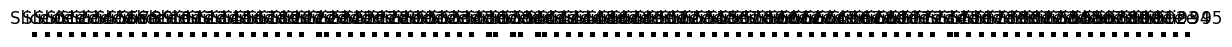

In [13]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

# Load the NIfTI file
nii_img = nib.load(output_file)

# Extract the data array
data = nii_img.get_fdata()

# Check the shape of the data
data_shape = data.shape
print("Shape of NIfTI data:", data_shape)

# Ensure the NIfTI data has the expected shape
if data_shape[0] == 1 and data_shape[1] == 2:
    # Extract the first volume
    single_volume_img = data[..., 0, 0]
    
    # Plot all the slices along the z-axis
    num_slices = data_shape[2]
    fig, axes = plt.subplots(1, num_slices, figsize=(15, 5))
    for i in range(num_slices):
        axes[i].imshow(single_volume_img[:, :, i], cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"Slice {i}")
    plt.show()
else:
    raise ValueError("The NIfTI data shape is not as expected.")
